In [1]:
import mlgrad.mlocation_scatter as mls
import mlgrad.avragg as avragg
import mlgrad.distance as distance
import mlgrad.func as func

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

In [2]:
df = pd.read_csv('data/stackloss.csv')
df

,STACKLOSS,AIRFLOW,WATERTEMP,ACIDCONC
0,42,80,27,89
1,37,80,27,88
2,37,75,25,90
3,28,62,24,87
4,18,62,22,87
5,18,62,23,87
6,19,62,24,93
7,20,62,24,93
8,15,58,23,87
9,14,58,18,80


In [3]:
#pd.plotting.scatter_matrix(df)

In [4]:
X = df["WATERTEMP"].values.reshape((-1,1))
X = np.asarray(X, "d")
Y = df["STACKLOSS"].values

# X = np.log(X)
# Y = np.log(Y)
print(len(Y))
print(17/21)

21
0.8095238095238095


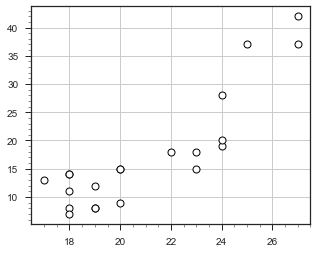

In [5]:
plt.figure(figsize=(5.0, 4.0))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [6]:
XY = np.c_[X, Y]

In [7]:
avg = avragg.WMAverage(averager_it(func.QuantileFunc(0.81, func.Sqrt(0.001))))
# avg = averager_it(func.QuantileFunc(0.81, func.Sqrt(0.001)))
mlse = mls.MLocationScatterEstimator(avg, n_iter=50, normalize_S=1)
mlse.fit(XY)

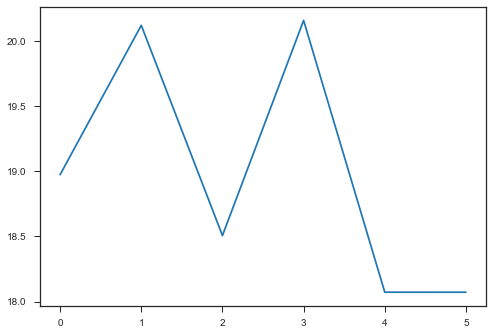

In [8]:
plt.plot(mlse.dvals)
plt.show()

In [9]:
loc, S = mlse.loc.base, mlse.S.base
distfunc = mlse.distfunc

loc0 = mls.standard_location(XY)
S0 = mls.standard_covariance(XY, loc0)
distfunc0 = distance.MahalanobisDistance(np.linalg.inv(S0))
# mls.scale_matrix(S0)
# S1 = np.linalg.inv(S0)

In [10]:
print(loc, loc0)
print(distfunc.S.base)
print(distfunc0.S.base)
print(mlse.K)

[20.34435662 14.59072751] [21.0952381  17.52380952]
<MemoryView of 'ndarray' object>
[[ 0.45012282 -0.12245943]
 [-0.12245943  0.04346471]]
6


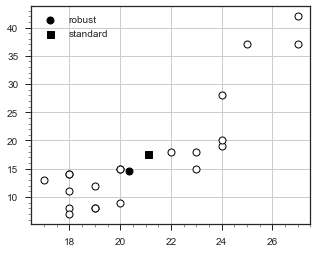

In [11]:
plt.figure(figsize=(5.0, 4.0))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.)
plt.scatter([loc[0]], [loc[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='o', label='robust')
plt.scatter([loc0[0]], [loc0[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='s', label='standard')
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.show()

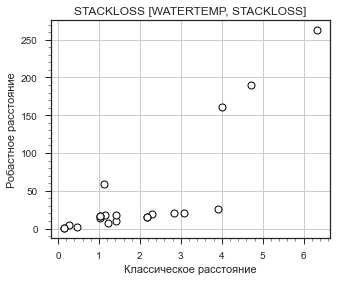

In [12]:
plt.figure(figsize=(5.0, 4.0))
D0 = [distfunc0(xy, loc0) for xy in XY]
D = [mlse.distfunc(xy, loc) for xy in XY]
plt.scatter(D0, D, c='w', edgecolors='k', linewidth=1)
plt.xlabel('Классическое расстояние')
plt.ylabel('Робастное расстояние')
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.savefig('fig/robust_clustering_distance_stackloss.eps')
plt.grid(1)
plt.minorticks_on()
plt.show()

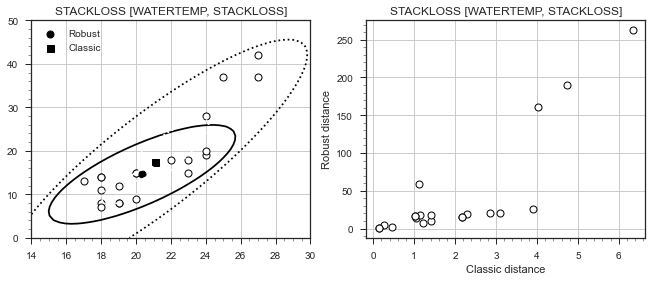

In [13]:
# _, eigvecs = np.linalg.eig(distfunc.S)
# _, eigvecs0 = np.linalg.eig(distfunc0.S)
plt.figure(figsize=(11.0, 4.0))
plt.subplot(1,2,1)
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.)
plt.scatter([loc[0]], [loc[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='o', label='Robust')
plt.scatter([loc0[0]], [loc0[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='s', label='Classic')
# plt.plot([loc[0]-eigvecs[0,0], loc[0], loc[0]+eigvecs[0,0]], 
#          [loc[1]-eigvecs[1,0], loc[1], loc[1]+eigvecs[1,0]], color='k')
# plt.plot([loc[0]-eigvecs[0,1], loc[0], loc[0]+eigvecs[0,1]], 
#          [loc[1]-eigvecs[1,1], loc[1], loc[1]+eigvecs[1,1]], color='k')
# plt.plot([loc0[0]-eigvecs0[0,0], loc0[0], loc0[0]+eigvecs0[0,0]], 
#          [loc0[1]-eigvecs0[1,0], loc0[1], loc0[1]+eigvecs0[1,0]], color='k', linestyle='--')
# plt.plot([loc0[0]-eigvecs0[0,1], loc0[0], loc0[0]+eigvecs0[0,1]], 
#          [loc0[1]-eigvecs0[1,1], loc0[1], loc0[1]+eigvecs0[1,1]], color='k', linestyle='--')
xrange = np.linspace(14., 30., 50)
yrange = np.linspace(0., 50., 50)
_XX, _YY = np.meshgrid(xrange, yrange)
_XY = np.c_[_XX.ravel(), _YY.ravel()]
_D = np.array([mlse.distfunc(loc, xy) for xy in _XY])
_D = _D.reshape(_XX.shape)
_D0 = np.array([distfunc0(loc0, xy) for xy in _XY])
_D0 = _D0.reshape(_XX.shape)
plt.contour(_XX, _YY, _D, levels=[1, 40])
plt.contour(_XX, _YY, _D0, levels=[1, 8], linestyles='dotted')
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.xlim(14, 30)
# plt.ylim(-2, 12)
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.subplot(1,2,2)
D0 = [distfunc0(xy, loc0) for xy in XY]
D = [mlse.distfunc(xy, loc) for xy in XY]
plt.scatter(D0, D, c='w', edgecolors='k', linewidth=1)
plt.xlabel('Classic distance')
plt.ylabel('Robust distance')
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.grid(1)
plt.minorticks_on()
plt.savefig('fig/robust_location_scatter_stackloss.eps')
plt.show()

In [14]:
XX = np.array(df.values, 'd', order='C')

In [15]:
avg2 = avragg.HMAverage(averager_it(func.QuantileFunc(0.80, func.Sqrt(0.001))))
# avg2 = averager_it(func.QuantileFunc(0.5, func.Sqrt(0.001)))
mlse2 = mls.MLocationScatterEstimator(avg2, n_iter=20)
mlse2.fit(XX)

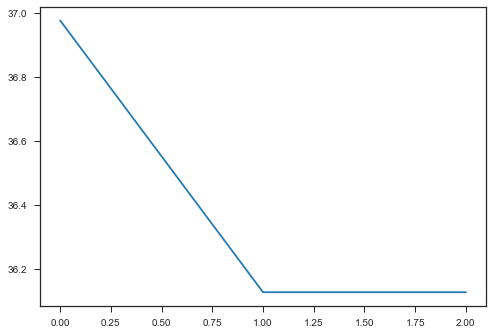

In [16]:
plt.plot(mlse2.dvals)
plt.show()

In [17]:
loc2, S2 = mlse2.loc.base, mlse2.S.base
S21 = np.linalg.inv(S2)

loc20 = mls.standard_location(XX)
S20 = mls.standard_covariance(XX, loc20)
mls.scale_matrix(S20)

In [18]:
distfunc2 = distance.MahalanobisDistance(np.linalg.inv(S2))
distfunc20 = distance.MahalanobisDistance(np.linalg.inv(S20))
D20 = [distfunc20(xx, loc20) for xx in XX]
D2 = [distfunc2(xx, loc2) for xx in XX]

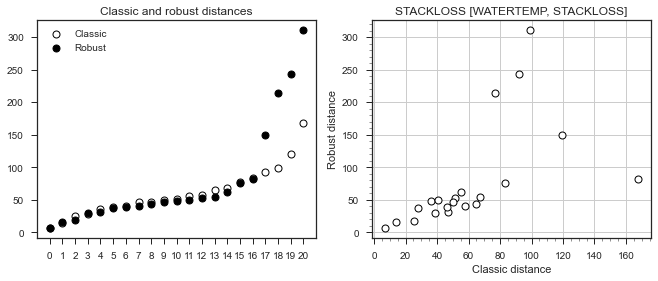

In [19]:
plt.figure(figsize=(11.0, 4.0))
plt.subplot(1, 2, 1)
plt.scatter(range(len(D20)), sorted(D20), c='w', edgecolor='k', linewidth=1, label='Classic')
plt.scatter(range(len(D2)), sorted(D2), c='k', edgecolor='k', linewidth=1, label='Robust')
plt.title('Classic and robust distances')
plt.xticks(range(len(D2)))
plt.legend()
# plt.subplot(1, 3, 2)
# plt.scatter(range(len(D2)), sorted(D2), c='w', edgecolor='k', linewidth=1)
# plt.ylabel('Robust distance')
# plt.xticks(range(len(D2)))
# plt.subplot(1, 3, 3)
# plt.scatter(D20, D2, c='w', edgecolor='k', linewidth=1)
# plt.scatter(D20, D2, c='w', edgecolors='k', linewidth=1, s=weights)

# plt.xlabel('Классическое расстояние')
# plt.ylabel('Робастное расстояние')
# plt.grid(1)
# plt.minorticks_on()
plt.subplot(1,2,2)
plt.scatter(D20, D2, c='w', edgecolors='k', linewidth=1)
plt.xlabel('Classic distance')
plt.ylabel('Robust distance')
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.grid(1)
plt.minorticks_on()
plt.savefig('fig/robust_location_scatter_stackloss_2.eps')
plt.show()

In [20]:
print(distfunc2.S.base)

[[ 1.28492357 -0.5240311  -1.99308671  0.20533814]
 [-0.5240311   0.82952146  0.31941397 -0.42882685]
 [-1.99308671  0.31941397  5.56736305 -0.43271701]
 [ 0.20533814 -0.42882685 -0.43271701  0.90703455]]


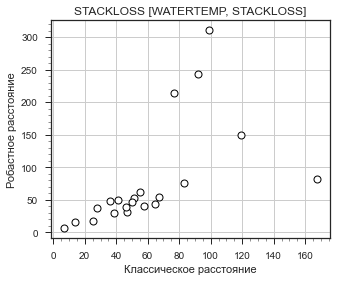

In [21]:
plt.figure(figsize=(5.0, 4.0))
plt.scatter(D20, D2, c='w', edgecolors='k', linewidth=1)
plt.xlabel('Классическое расстояние')
plt.ylabel('Робастное расстояние')
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.savefig('fig/robust_clustering_distance_stackloss2.eps')
plt.grid(1)
plt.minorticks_on()
plt.show()

894.6837852848726 9169.666584208922


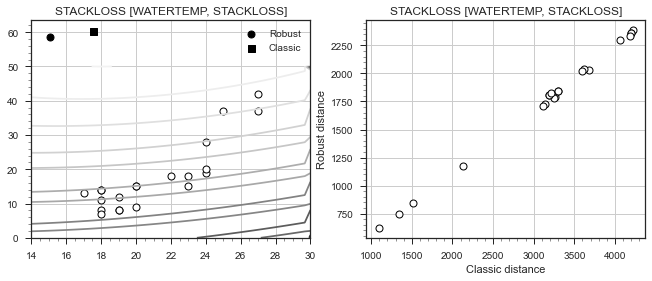

In [22]:
# _, eigvecs = np.linalg.eig(distfunc.S)
# _, eigvecs0 = np.linalg.eig(distfunc0.S)
plt.figure(figsize=(11.0, 4.0))
plt.subplot(1,2,1)
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.)
plt.scatter([loc2[0]], [loc2[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='o', label='Robust')
plt.scatter([loc20[0]], [loc20[1]], s=49, c='k', edgecolors='k', linewidth=1., marker='s', label='Classic')
# plt.plot([loc[0]-eigvecs[0,0], loc[0], loc[0]+eigvecs[0,0]], 
#          [loc[1]-eigvecs[1,0], loc[1], loc[1]+eigvecs[1,0]], color='k')
# plt.plot([loc[0]-eigvecs[0,1], loc[0], loc[0]+eigvecs[0,1]], 
#          [loc[1]-eigvecs[1,1], loc[1], loc[1]+eigvecs[1,1]], color='k')
# plt.plot([loc0[0]-eigvecs0[0,0], loc0[0], loc0[0]+eigvecs0[0,0]], 
#          [loc0[1]-eigvecs0[1,0], loc0[1], loc0[1]+eigvecs0[1,0]], color='k', linestyle='--')
# plt.plot([loc0[0]-eigvecs0[0,1], loc0[0], loc0[0]+eigvecs0[0,1]], 
#          [loc0[1]-eigvecs0[1,1], loc0[1], loc0[1]+eigvecs0[1,1]], color='k', linestyle='--')
xrange = np.linspace(14., 30., 50)
yrange = np.linspace(0., 50., 50)
_XX, _YY = np.meshgrid(xrange, yrange)
_XY = np.c_[_XX.ravel(), _YY.ravel()]
_D2 = np.array([mlse2.distfunc(loc2, xy) for xy in _XY])
_D2 = _D2.reshape(_XX.shape)
_D20 = np.array([distfunc20(loc20, xy) for xy in _XY])
_D20 = _D20.reshape(_XX.shape)
print(_D20.min(), _D20.max())
plt.contour(_XX, _YY, _D2) #, levels=[1, 40])
plt.contour(_XX, _YY, _D20) #, levels=[3, 50], linestyles='dotted')
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.xlim(14, 30)
# plt.ylim(-2, 12)
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.subplot(1,2,2)
D20 = [distfunc20(xy, loc20) for xy in XY]
D2 = [mlse2.distfunc(xy, loc2) for xy in XY]
plt.scatter(D20, D2, c='w', edgecolors='k', linewidth=1)
plt.xlabel('Classic distance')
plt.ylabel('Robust distance')
plt.title('STACKLOSS [WATERTEMP, STACKLOSS]')
plt.grid(1)
plt.minorticks_on()
# plt.savefig('fig/robust_location_scatter_stackloss.eps')
plt.show()